#Linear Elasticity in 3D for Polycrystalline Microstructures

Authors: Noah Paulson, Andrew Medford, David Brough

## Introduction

This example demonstrates the use of MKS to predict strain fields in a polycrystalline sample. The Generalized Spherical Harmonic (GSH) basis is introduced and used for a material with hexagonal crystal symmetry. The effect of different levels of truncation in the GSH basis functions are examined, as well as the effect of selecting an incorrect crystal symmetry.

## Modeling with MKS

### Obtaining Data for MKS Calibration and Validation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

To start off we need to obtain data from somewhere. In order to make things easy the pymks_share package is used to import data.

In [2]:
from pymks_share import DataManager

manager = DataManager('pymks.me.gatech.edu')
X, y  = manager.fetch_data('random hexagonal orientations')

print X.shape
print y.shape

(50L, 21L, 21L, 21L, 3L)
(50L, 21L, 21L, 21L)


The X variable contains a set of 3 Bunge Euler angles at each spatial point, corresponding to the crystal orientation. The y variable is the '11' component  of the strain tensor as obtained by a finite element simulation ($\epsilon_{xx}$). We can visualize this by plotting a slice of a 3-D microstructure ($\phi_1$ angle only) and its corresponding strain response.

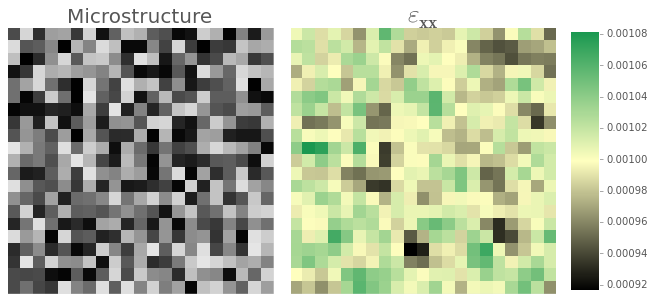

In [3]:
from pymks.tools import draw_microstructure_strain

n = X.shape[1]
center = (n-1) / 2
draw_microstructure_strain(X[0, center, :, :, 0], y[0, center])

This may not mean much, but trust us that the $\epsilon_{xx}$ field is rather expensive to calculate. In principle we could visualize this in 3 dimensions using a package like mayavi, but for this tutorial we will just look at a single slice down through the center.

In order to ensure that our models are valid, we need to split the data into "calibration" and "validation" sets. The idea here is that we train the model on a subset of N_cal datasets, then test the model on the rest. This is a crude form of "cross validation", and will give us confidence that we have not over-fit the model.

In [4]:
N_cal = 40
X_cal = X[0:N_cal, ...]
X_val = X[N_cal:, ...]
y_cal = y[0:N_cal, ...]
y_val = y[N_cal:, ...]
print X_cal.shape
print X_val.shape

(40L, 21L, 21L, 21L, 3L)
(10L, 21L, 21L, 21L, 3L)


We can see that we have 40 calibration sets, and 10 validation sets. Ideally we would have a lot more data to validate the model, but at least the 10 should give us an idea of how transferable the model is.

Next we need to set up the MKS "localization model" which will be used to compute all the parameters we need for the machine to "learn" how the input microstructure field is related to the output strain field. In order to capture the orientation dependence we are going to use a basis set of "generalized spherical harmonics". A quick Google search of "generalized spherical harmonics" will tell you that these are pretty trippy functions (nearly all the results are from technical journals!).

In the GSH basis n_states refers to the set of basis functions we want to work with. In this example we want to use the first 5 basis functions, so we assign a list containing indices 0-5 to n_states (we could alternately pass the integer 5 to n_states and PyMKS would automatically know to use the first 5 basis functions!). If we only wanted the 5th basis function we would simply pass n_states a list with only one entry: n_states=[5].

We also need to specify the symmetry we want (and the symmetric domain) of our basis function. PyMKS makes this very easy; we can simply give domain a string specifying the desired crystal symmetry. For example, passing 'hexagonal' specifies a hexagonal crystal symmetry, while passing 'cubic' specifies cubic symmetry. If we pass "triclinic", or don't define the domain at all the non-symmetrized version of the GSH basis is used.

### Calibrating First Order Influence Coefficients

In [5]:
from pymks import MKSLocalizationModel
from pymks.bases import GSHBasis

gsh_hex_basis = GSHBasis(n_states=np.arange(6), domain="hexagonal")

Now we have selected the basis functions, perhaps we want to know more about what we've selected. Let's ask for the l, m and n indices of the GSH basis functions we've selected (Note that this is an advanced feature and may only be useful for the most seasoned materials scientists!).

In [6]:
print gsh_hex_basis.basis_indices

[[ 0  0  1]
 [ 2 -2  1]
 [ 2 -1  1]
 [ 2  0  1]
 [ 2  1  1]
 [ 2  2  1]]


Now all of the complexity of the GSH basis set will be taken care of by pyMKS from here on out. We just need to fit the model:

In [7]:
model = MKSLocalizationModel(basis=gsh_hex_basis)

model.fit(X_cal, y_cal)

and then we can look at the "influence coefficients" which capture the connection between the input and output fields. Notice that there are 6 (complex valued) influence coefficients, because we had 6 "states" in the basis set. In other words, there are 2 fields of influence coefficients for each basis set. Again, we are only looking at a slice through the center in order to avoid the complexities of visualizing 3D data.

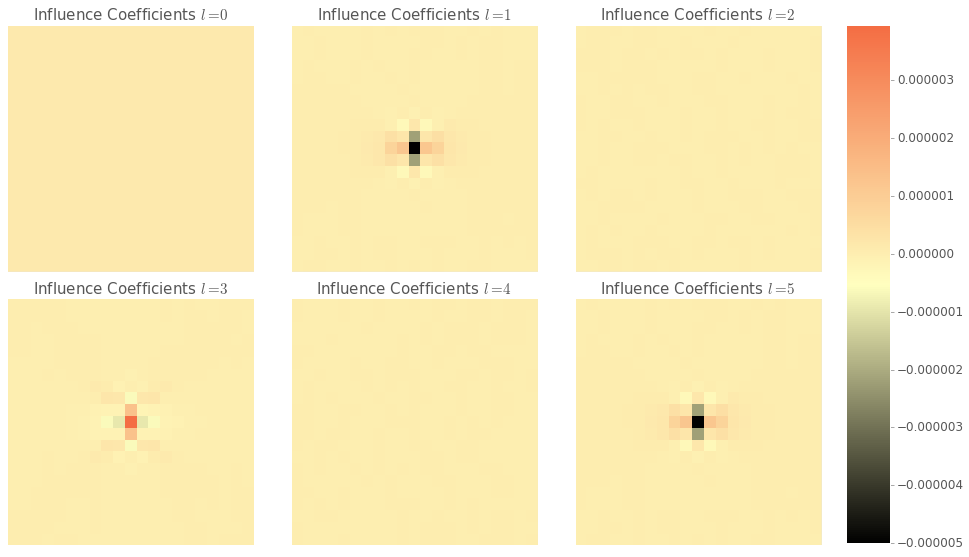

In [15]:
from pymks.tools import draw_coeff

coef_ = model.coef_
draw_coeff(np.real(coef_[:,center, :, :]), figsize=(2, 3))

we also want to plot the imaginary components of the influence coefficients, you can't forget about these when using the GSH basis!

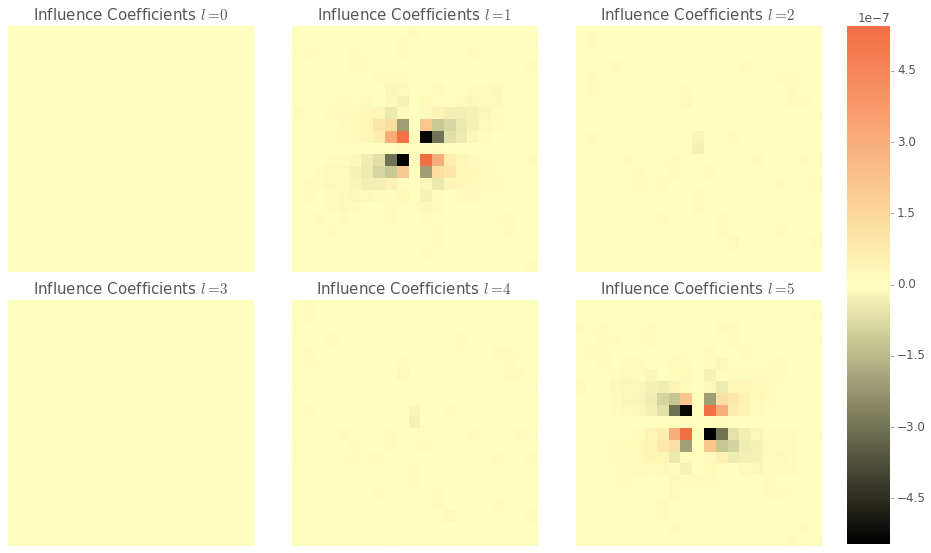

In [14]:
draw_coeff(np.imag(coef_[:,center, :, :]), figsize=(2, 3))

We can see that the coefficients for some basis sets have significant values, while others are mostly zero. This means that in principle we could probably describe the system with fewer basis states. We also notice that when there are non-zero components, they are typically centered near zero. This is intuitive, since it tells us that the elastic response of the material is local, as we would expect (and as can be seen in the other elasticity tutorials).

## Prediction of Strain Fields for Validation Microstructures

Now we want to use these coefficients to predict the response of the validation set, and ensure that the results are in line with the outputs of the full simulation.

In [16]:
y_predict = model.predict(X_val)

First let's simply compare slices of the $\epsilon_{xx}$ strain fields for one of our validation microstructures

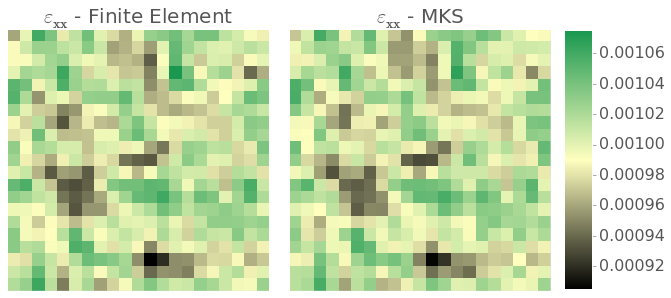

In [17]:
from pymks.tools import draw_strains_compare

draw_strains_compare(y_val[0, center], y_predict[0, center])

So it looks like the MKS is working pretty well in this case, but it is worth seeing if we can do even better.

### Improving the MKS Results

The next thing to try is to include even more basis functions:

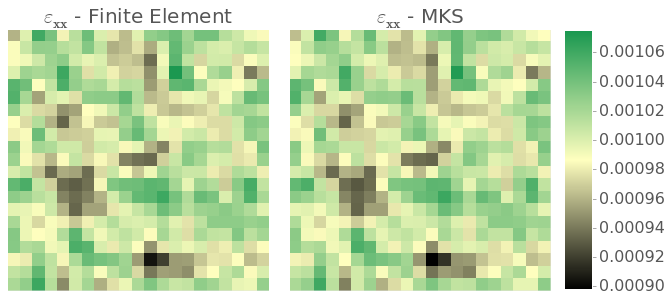

In [25]:
gsh_hex_basis = GSHBasis(n_states=np.arange(20), domain='hexagonal')
model = MKSLocalizationModel(basis=gsh_hex_basis)
model.fit(X_cal, y_cal)
y_predict = model.predict(X_val)
draw_strains_compare(y_val[0, center], y_predict[0, center])

Clearly now the results are very good. You might ask if we have too few or too many basis functions? First, let's look at the influence coefficients and what is going on.

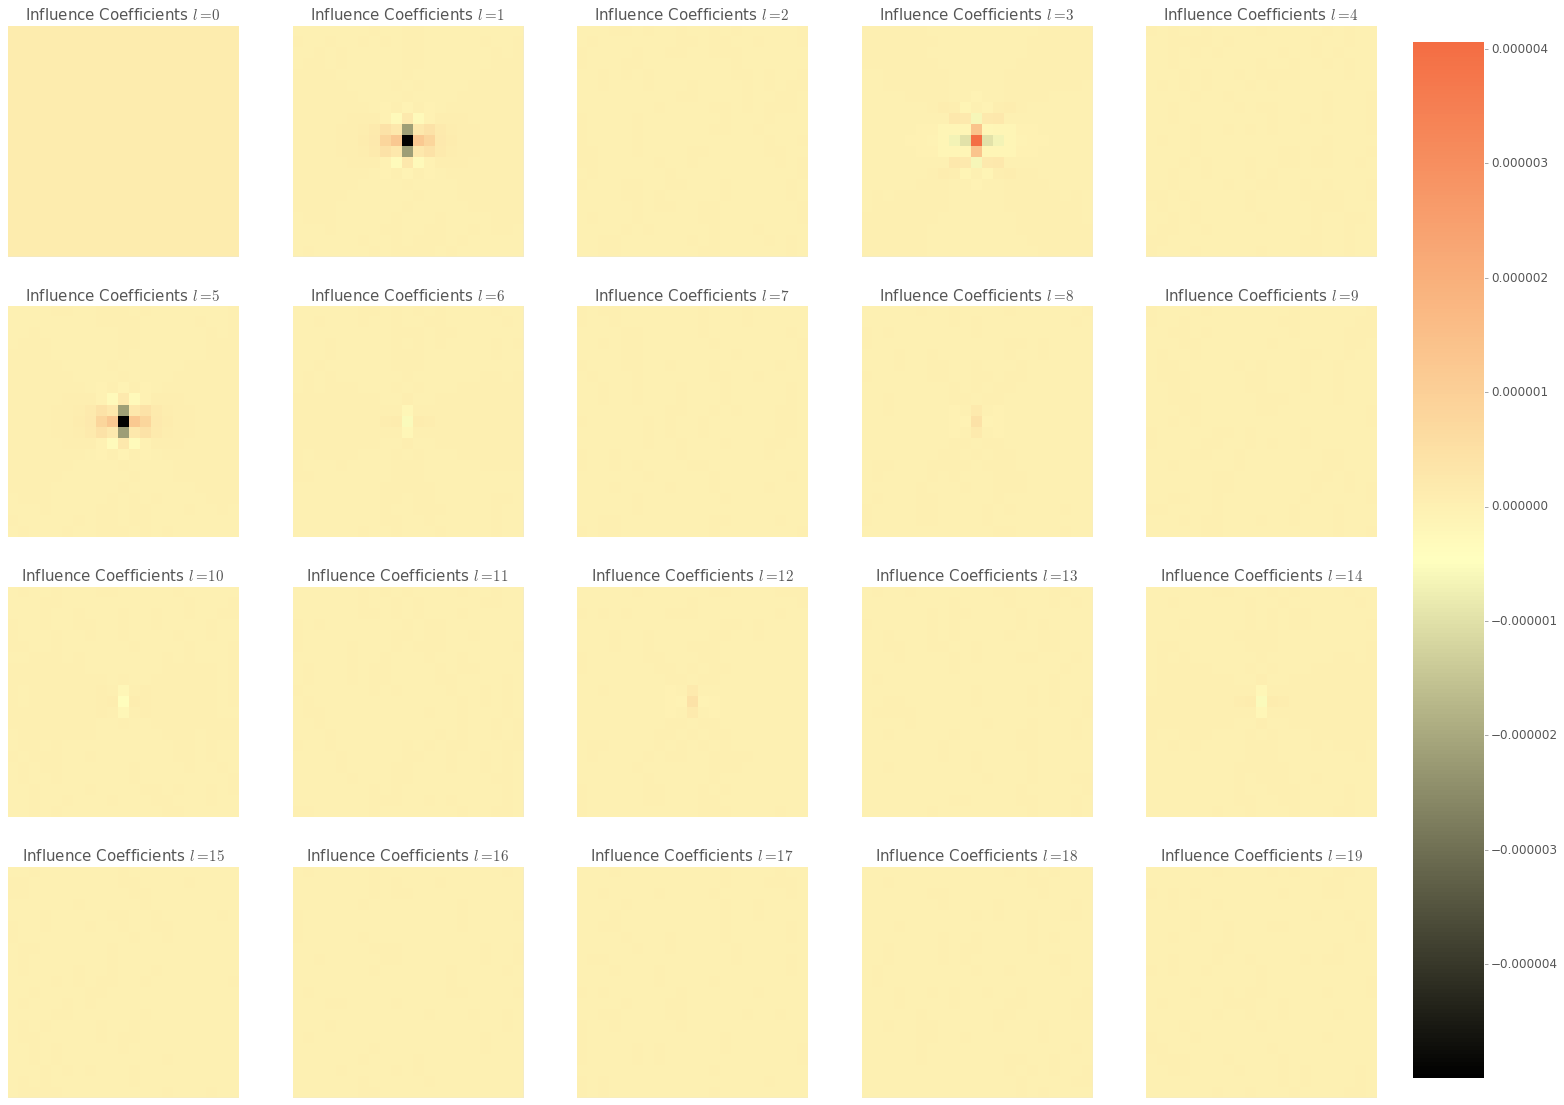

In [26]:
from pymks.tools import draw_coeff

coeff = model.coef_
draw_coeff(np.real(coeff[:,center, :, :]), figsize=(4, 5))

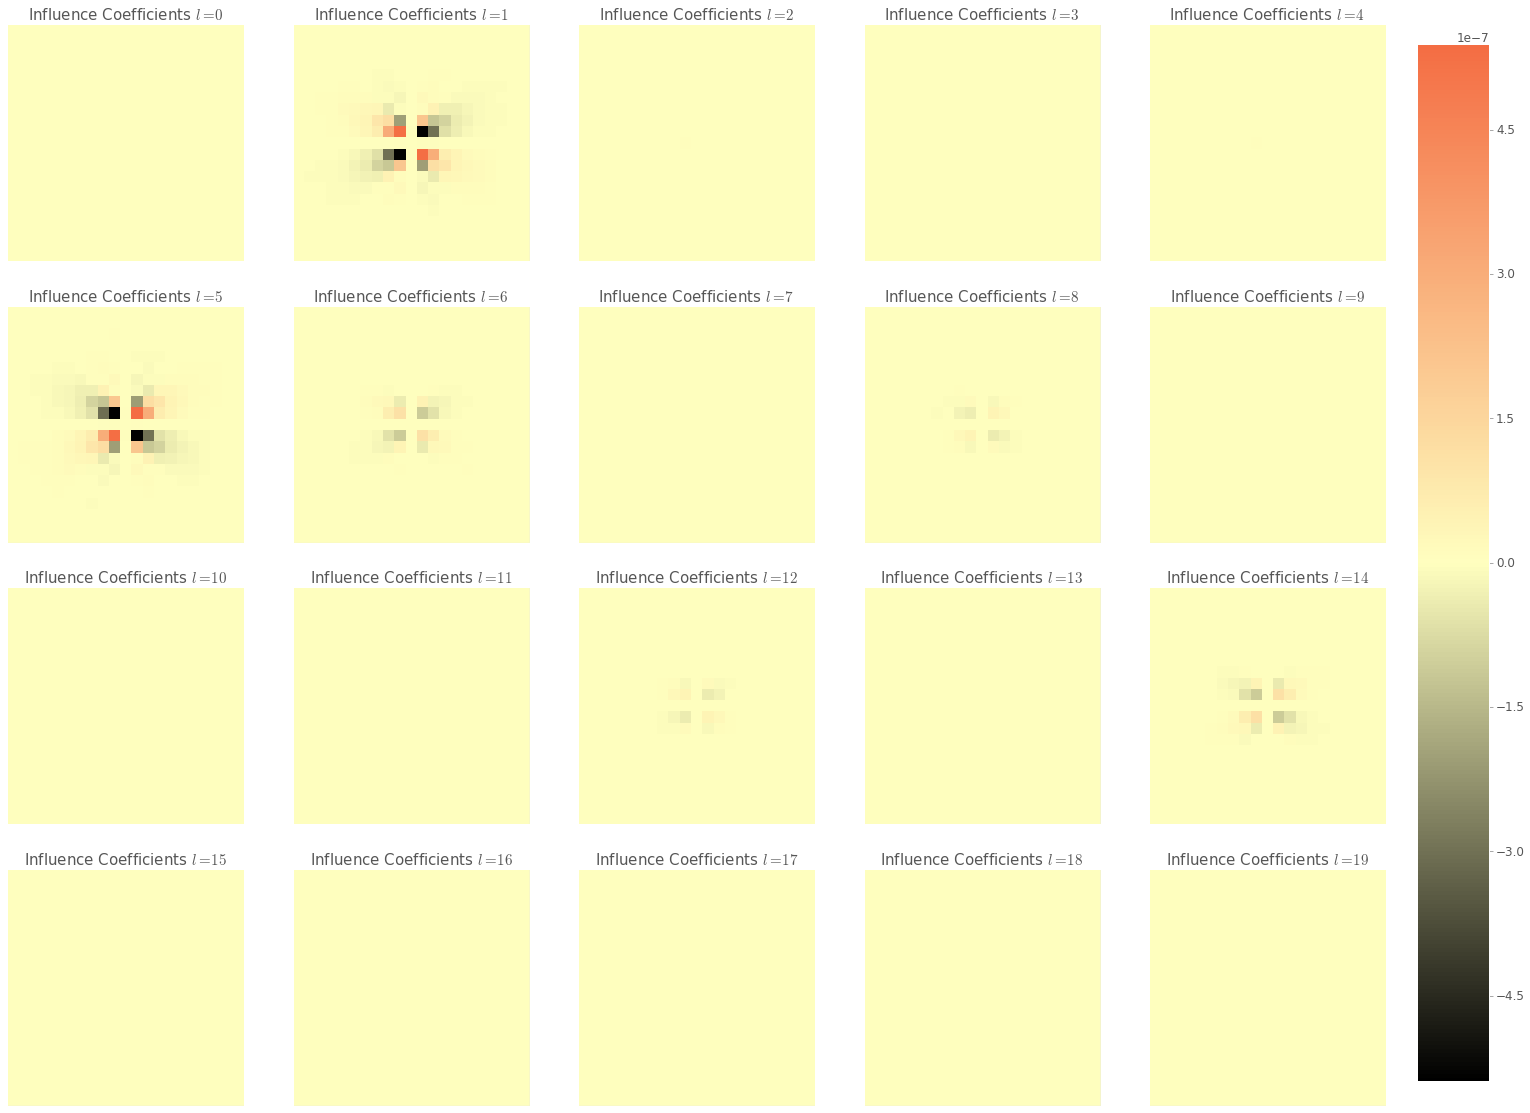

In [27]:
draw_coeff(np.imag(coeff[:,center, :, :]), figsize=(4, 5))

If we look carefully at the influence coefficients we notice that they appear to be identically zero for the 15th basis function and beyond. If we wanted to be thorough we would want to check the influence coefficients for even more basis functions, but for the purposes of this example we can be satisfied that we only need the first 15.

Let's redo the study once more with only the first 15 basis functions and hexagonal symmetry.

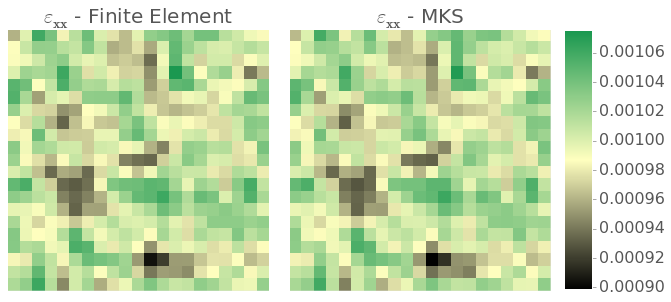

In [21]:
gsh_hex_basis = GSHBasis(n_states=np.arange(15), domain='hexagonal')
model = MKSLocalizationModel(basis=gsh_hex_basis)
model.fit(X_cal, y_cal)
y_predict = model.predict(X_val)
draw_strains_compare(y_val[0, center], y_predict[0, center])

As we expected the results look great, probably even better than the previous iteration.

### Selection of the Wrong Crystal Symmetry!

Finally let's take a look at what happens when we choose the wrong crystal symmetry.

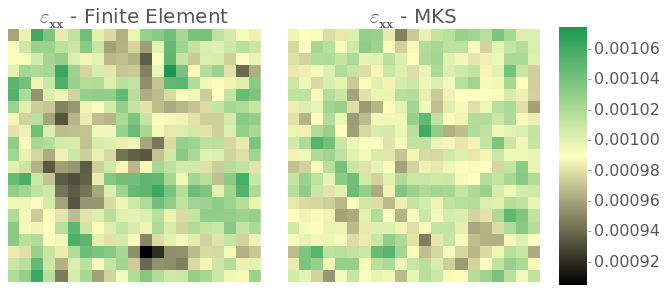

In [22]:
gsh_cube_basis = GSHBasis(n_states=np.arange(15), domain='cubic')
model = MKSLocalizationModel(basis=gsh_cube_basis)
model.fit(X_cal, y_cal)
y_predict = model.predict(X_val)
draw_strains_compare(y_val[0, center], y_predict[0, center])

As you might expect, when the wrong gsh basis functions are used for our problem the results are pretty bad!

## References

[1] Binci M., Fullwood D., Kalidindi S.R., *A new spectral framework for establishing localization relationships for elastic behav ior of composites and their calibration to finite-element models*. Acta Materialia, 2008. 56 (10): p. 2272-2282 [doi:10.1016/j.actamat.2008.01.017](http://dx.doi.org/10.1016/j.actamat.2008.01.017).


[2] Landi, G., S.R. Niezgoda, S.R. Kalidindi, *Multi-scale modeling of elastic response of three-dimensional voxel-based microstructure datasets using novel DFT-based knowledge systems*. Acta Materialia, 2009. 58 (7): p. 2716-2725 [doi:10.1016/j.actamat.2010.01.007](http://dx.doi.org/10.1016/j.actamat.2010.01.007).


[3] Yabansu, Y.C., Patel, D.K., Kalidindi, S.R. "Calibrated localization relationships for elastic response of polycrystalline aggregates." Acta Materialia 81 (2014): 151-160. [doi:10.1016/j.actamat.2014.08.022](http://dx.doi.org/10.1016/j.actamat.2014.08.022).
